### Sentiment Analysis Pipeline using Transformers

In [1]:
# Install Transformer
# pip install transformers

In [2]:
# Download the dataset
# ! wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

In [3]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import pathlib

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
HOME = pathlib.Path().home()
CURRENT_DIR = pathlib.Path().absolute() 
DATA = str(CURRENT_DIR) + "/data"

In [5]:
#basic usage of Transformers

feedbacks = ["I can't say this is a good movie", \
    "this a bad one", \
        "I actually like the movie"]

#create pipeline
Classifier = pipeline("sentiment-analysis")

#preforming sentiment analysis on raw text
print(Classifier(feedbacks))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.9917254447937012}, {'label': 'NEGATIVE', 'score': 0.9997909665107727}, {'label': 'POSITIVE', 'score': 0.9996663331985474}]


In [6]:
import torch

In [7]:
import torch

# check if GPU is available on machine
print(f" GPU is available:{torch.cuda.is_available()}")

# check which GPU device
# print(f" GPU is available:{torch.cuda.current_device()}")


 GPU is available:False


In [8]:
df = pd.read_csv(DATA + "/AirlineTweets.csv") 
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<AxesSubplot:>

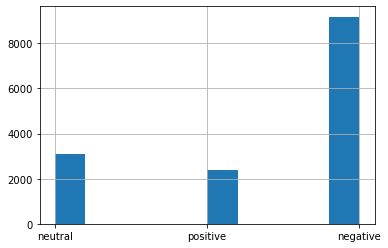

In [9]:
df = df[['text', 'airline_sentiment']].copy()
df['airline_sentiment'].hist()

3 classes to predict :multi classification problem
imbalenced data set : negative texts are over presented compared to the other two classes

In [10]:
# filter out neutral classes because our pre trained model only predict positive or negative
df = df[df["airline_sentiment"] != "neutral"]

#encode classes
target_map = {'positive' : 1,\
     'negative' :  0}
df['target'] = df["airline_sentiment"].map(target_map)

In [11]:
display(df.head())
print(f" number of rows: {len(df)}")

,text,airline_sentiment,target
1,@VirginAmerica plus you've added commercials t...,positive,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0
5,@VirginAmerica seriously would pay $30 a fligh...,negative,0
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,1


 number of rows: 11541


In [12]:
predictions = Classifier(list(df['text'].iloc[0:100]))

In [13]:
# list(df['text'].iloc[0:100])

In [14]:
predictions 

[{'label': 'POSITIVE', 'score': 0.6070870757102966},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854251742362976},
 {'label': 'POSITIVE', 'score': 0.9553210139274597},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

#### Computing AUC

In [15]:
# computing probabily of positive feedbacks
df_sample = df.iloc[0:100]
df_sample 

,text,airline_sentiment,target
1,@VirginAmerica plus you've added commercials t...,positive,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0
5,@VirginAmerica seriously would pay $30 a fligh...,negative,0
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,1
...,...,...,...
144,@VirginAmerica you have amazing staff &amp; su...,positive,1
145,@VirginAmerica I paid the premium to fly you a...,negative,0
146,@VirginAmerica question: is it not possible to...,negative,0
147,Always have it together!!! You're welcome! RT ...,positive,1


In [16]:
#Compute accuracy
probs = [d["score"] if d["label"].startswith('P') else 1 - d["score"] for d in predictions]

preds = np.array([ 1 if d["label"].startswith("P") else 0 for d in predictions ])

accuracy = np.mean(df_sample["target"] == preds)

print(f"acc: {accuracy}")

acc: 0.92


In [17]:
#confusion matrix
cm = confusion_matrix(df_sample['target'] ,  preds, normalize = "true")
cm

array([[0.96363636, 0.03636364],
       [0.13333333, 0.86666667]])

In [20]:
def plot_cm(cm):
    classes =["negative", "positive"]
    df_cm = pd.DataFrame(cm, index=classes , columns=classes)
    ax = sn.heatmap(df_cm , annot= True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Traget")


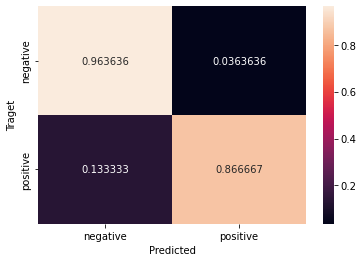

In [21]:
plot_cm(cm)

In [26]:
# Computing metrics
display (f1_score(df_sample['target'] , preds))
display(f1_score(1 - df_sample['target'] , 1 - preds))

0.9069767441860465

0.9298245614035089

In [27]:
display(roc_auc_score(df_sample["target"] , preds))
display(roc_auc_score(1 - df_sample["target"] ,1 - preds))

0.9151515151515152

0.9151515151515152